### Tổ chức thư mục chứa ảnh train theo cấu trúc sau:

    ├── DUYETLV
    │   ├── face-43.jpg
    │   ├── face-5.jpg
    │   ├── Screen Shot 2019-02-27 at 6.38.53 PM.png
    │   ├── Screen Shot 2019-02-27 at 6.39.12 PM.png
    │   └── Screen Shot 2019-02-27 at 6.39.22 PM.png
    ├── DUYNN
    │   ├── duynn01.jpg
    │   └── duynn02.jpg
    ├── HANTQ
    │   └── HANTQ.jpg
    ├── HOAINT
    ├── HOAISD
    │   └── face_21.jpg
    ├── HUNGNV
    │   ├── face15.jpg
    │   └── face65.jpg
    ├── LOCTH
    │   ├── locth-01.jpg
    │   ├── locth-02.jpg
    │   └── locth-03.jpg
    ├── MINHHA
    │   ├── face_42.jpg
    │   ├── face_4.jpg
    │   ├── face_51.jpg
    │   └── face_58.jpg
    ├── MYNH
    │   └── face_77.jpg
    ├── NHANTH
    │   └── face_50.jpg
    ├── PHUCTN
    ├── PHUONGTD
    ├── QUANVM
    │   ├── 0.png
    │   ├── 1.png
    │   └── 2.png
    ├── TAIHPT
    │   └── face_19.jpg
    ├── TANTD
    │   ├── image_1.jpg
    │   ├── image_2.jpg
    │   ├── image_3.jpg
    │   └── image_4.jpg
    ├── THAODNT
    │   └── face_52.jpg
    ├── THUONGNC
    ├── ThuyLTN
    │   └── ThuyLTN.png
    ├── TIENBDT
    ├── TRUONGTX
    │   └── IMG_5328_face002.jpg
    ├── TUANPV
    ├── TULG
    │   ├── face_102.jpg
    │   ├── face_109.jpg
    │   ├── face_34.jpg
    │   ├── face_46.jpg
    │   └── face_66.jpg
    ├── VULQ
    │   ├── vulq01.jpg
    │   ├── vulq02.jpg
    │   ├── vulq03.jpg
    │   └── vulq04.jpg
    └── VUND
        ├── vund2.png
        └── vund3.png

### Sử dụng MT-CNN để nhận dạng, sửa lại kích thước ảnh các khuôn mặt về cùng một kích thước
    python src/align/align_dataset_mtcnn.py ~/datasets/uit/cvk13/FaceDB ~/datasets/uit/cvk13/mtcnnpy_160 --image_size 160 --margin 32 --random_order --gpu_memory_fraction 0.6

### Sau khi có được các ảnh train cùng kích thước (160x160), tiến hành train
    python src/create_face_embeddings.py --algn_path ~/datasets/uit/cvk13/mtcnnpy_160 --embedding ~/datasets/uit/cvk13/models/uit.pickle

#### Kết quả trả về là file model tên là *uit.pickle*

### Chương trình nhận dạng khuôn mặt
#### Nạp các thư viện cần thiết

In [3]:
import os
from os import listdir
from os.path import isfile, join
import sys
import numpy as np
import cv2
import tensorflow as tf
import pickle
import facenet
import align.detect_face
import tfinit
import imageio
from scipy import misc
from facenet import load_img
import matplotlib.pyplot as plt

#### Khởi tạo các tham số mặc định, trong đó tham số *k_threshold* làm chương trình không gán tên người vào khuôn mặt khi có sự khác biệt quá lớn

In [4]:
lfw_batch_size        = 100
image_size            = 160
detect_multiple_faces = True
gpu_memory_fraction   = 0.6
margin                = 44
k_threshold           = 0.810

#### Khai báo biến thư mục chứa ảnh test

In [5]:
img_path="dataset/test"
img_files = [f for f in listdir(img_path) if isfile(join(img_path, f))]

#### Nạp file model đã có được từ bước train ở trên và file model đã train sẵn của Facenet

In [6]:
with open('../datasets/uit/cvk13/models/uit.pickle','rb') as f:
        feature_array = pickle.load(f)

model_exp = '../models/20180408-102900'
sess_tf, pnet, rnet, onet = tfinit.tf_init(model_exp, 'model-20180408-102900.meta', 'model-20180408-102900.ckpt-90', gpu_memory_fraction)
print('Loaded pre-trained models in', model_exp)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Restoring parameters from ../models/20180408-102900/model-20180408-102900.ckpt-90
Loaded pre-trained models in ../models/20180408-102900


#### Hàm xác định vị trí các khuôn mặt và trả về hình ảnh các khuôn mặt trong ảnh

In [7]:
def align_face (img, pnet, rnet, onet):
        minsize = 20 # minimum size of face
        threshold = [ 0.7, 0.8, 0.8 ]  # three steps's threshold
        factor = 0.709 # scale factor

        if img.size == 0:
                print("empty array")
                return False,img,[0,0,0,0]

        if img.ndim<2:
            print('Unable to align')

        if img.ndim == 2:
            img = to_rgb(img)

        img = img[:,:,0:3]

        bounding_boxes, _ = align.detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)

        nrof_faces = bounding_boxes.shape[0]


        if nrof_faces==0:
            return False,img,[0,0,0,0]
        else:
            det = bounding_boxes[:,0:4]
            det_arr = []
            img_size = np.asarray(img.shape)[0:2]
            if nrof_faces>1:
                if detect_multiple_faces:
                    for i in range(nrof_faces):
                        det_arr.append(np.squeeze(det[i]))
                else:
                    bounding_box_size = (det[:,2]-det[:,0])*(det[:,3]-det[:,1])
                    img_center = img_size / 2
                    offsets = np.vstack([ (det[:,0]+det[:,2])/2-img_center[1], (det[:,1]+det[:,3])/2-img_center[0] ])
                    offset_dist_squared = np.sum(np.power(offsets,2.0),0)
                    index = np.argmax(bounding_box_size-offset_dist_squared*2.0) # some extra weight on the centering
                    det_arr.append(det[index,:])
            else:
                det_arr.append(np.squeeze(det))
            if len(det_arr)>0:
                faces = []
                bboxes = []
                for i, det in enumerate(det_arr):
                    det = np.squeeze(det)
                    bb = np.zeros(4, dtype=np.int32)
                    bb[0] = np.maximum(det[0]-margin/2, 0)
                    bb[1] = np.maximum(det[1]-margin/2, 0)
                    bb[2] = np.minimum(det[2]+margin/2, img_size[1])
                    bb[3] = np.minimum(det[3]+margin/2, img_size[0])
                    cropped = img[bb[1]:bb[3],bb[0]:bb[2],:]
                    scaled = misc.imresize(cropped, (image_size, image_size), interp='bilinear')
                    faces.append(scaled)
                    bboxes.append(bb)
                    
                return True,faces,bboxes

#### Hàm xác định danh tính khuôn mặt

In [8]:
def identify_person(image_vector, feature_array, k=9):
        top_k_ind = np.argsort([np.linalg.norm(image_vector - pred_row) \
                        for ith_row, pred_row in enumerate(feature_array.values())])[:k]

        diff = np.linalg.norm(image_vector - list(feature_array.values())[top_k_ind[0]])

        result = []
        for i in range(k):
            result.extend([list(feature_array.keys())[top_k_ind[i]]])

        if (diff < k_threshold):
            return result[0], diff
        else:
            return 'unknown/unknown_000.png', diff

#### Hàm chính của chương trình
1. Khởi tạo Tensorflow
1. Đọc các ảnh trong thư mục
1. Chuyển ảnh màu về ảnh xám
1. Thực hiện phát hiện khuôn mặt trên ảnh xám
1. So khuôn mặt trong ảnh test với ảnh đã lưu trong file model
1. Hiển thị ra kết quả

/data/0/home/truongtx8/.virtualenvs/jupyter/lib/python3.5/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/data/0/home/truongtx8/.virtualenvs/jupyter/lib/python3.5/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


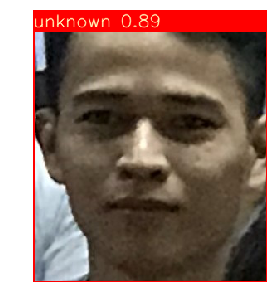

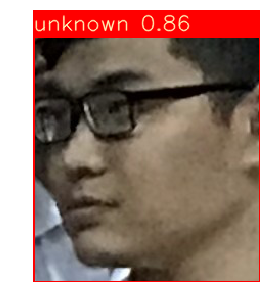

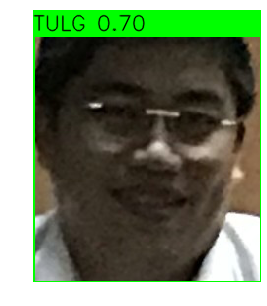

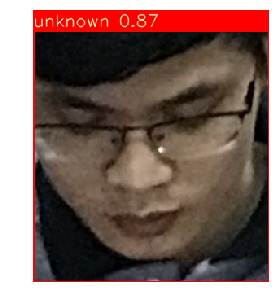

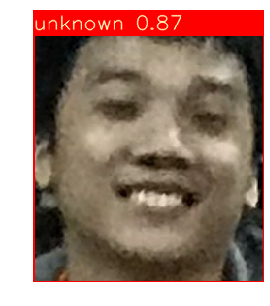

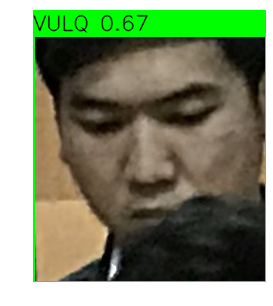

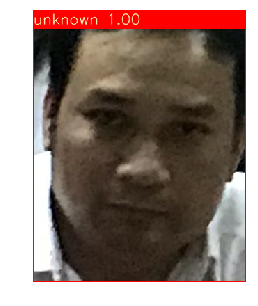

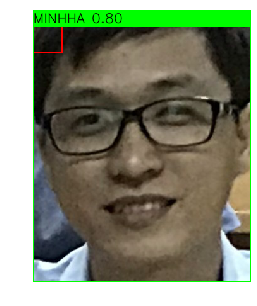

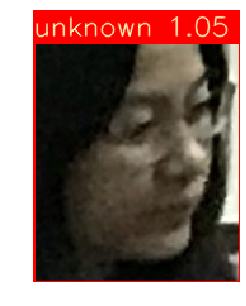

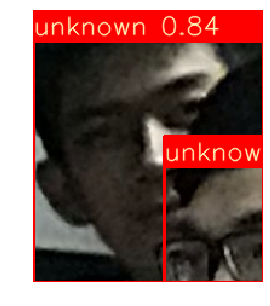

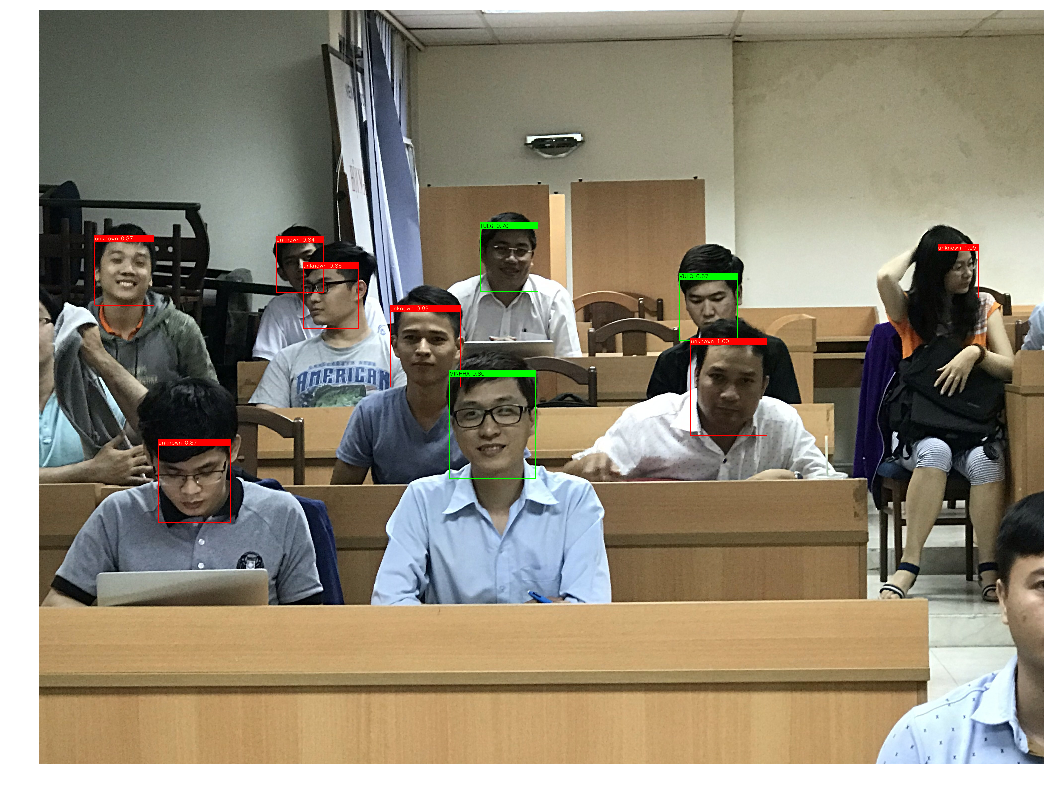

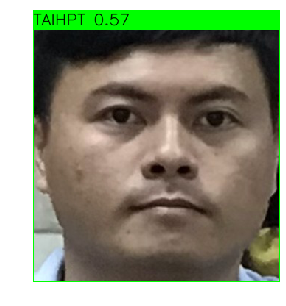

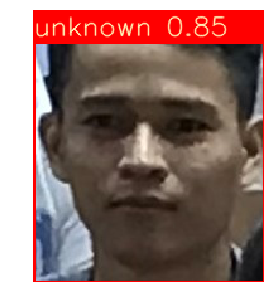

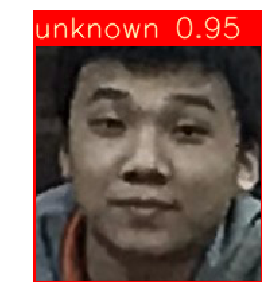

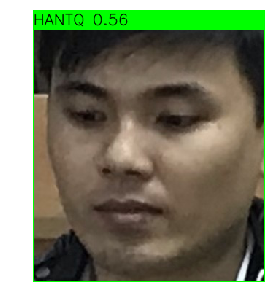

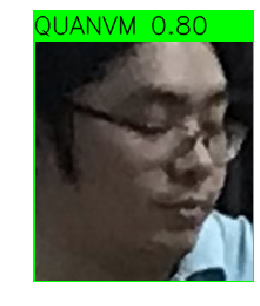

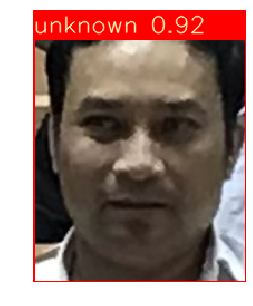

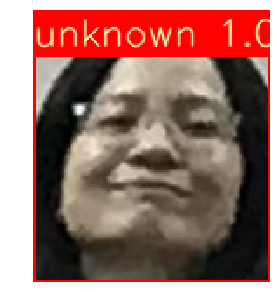

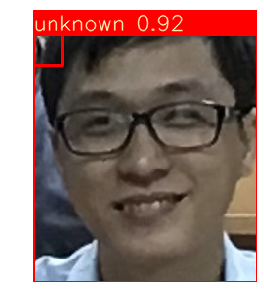

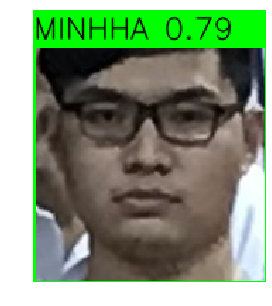

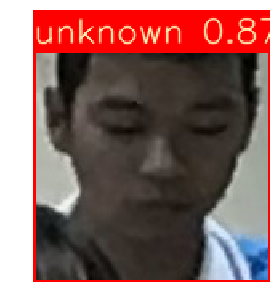

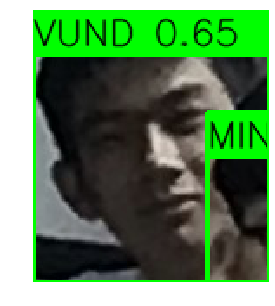

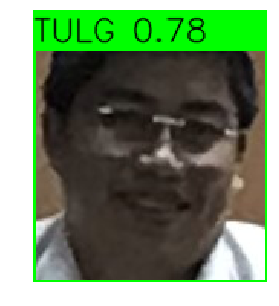

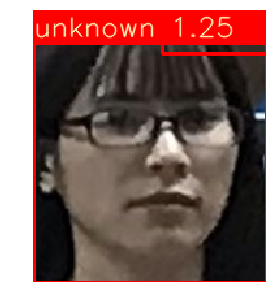

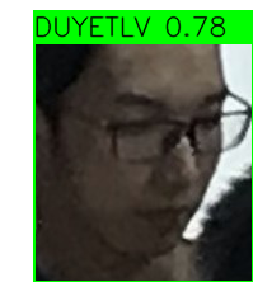

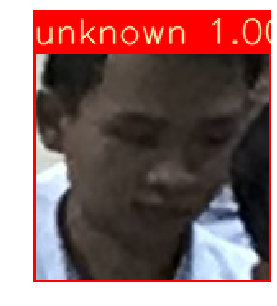

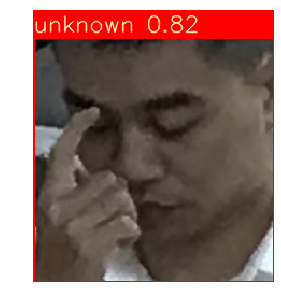

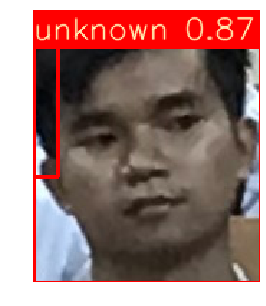

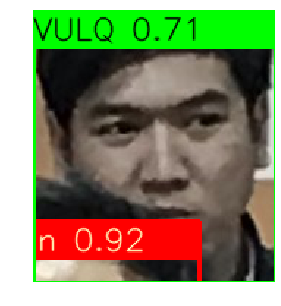

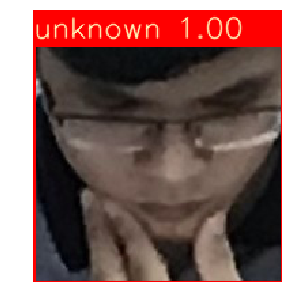

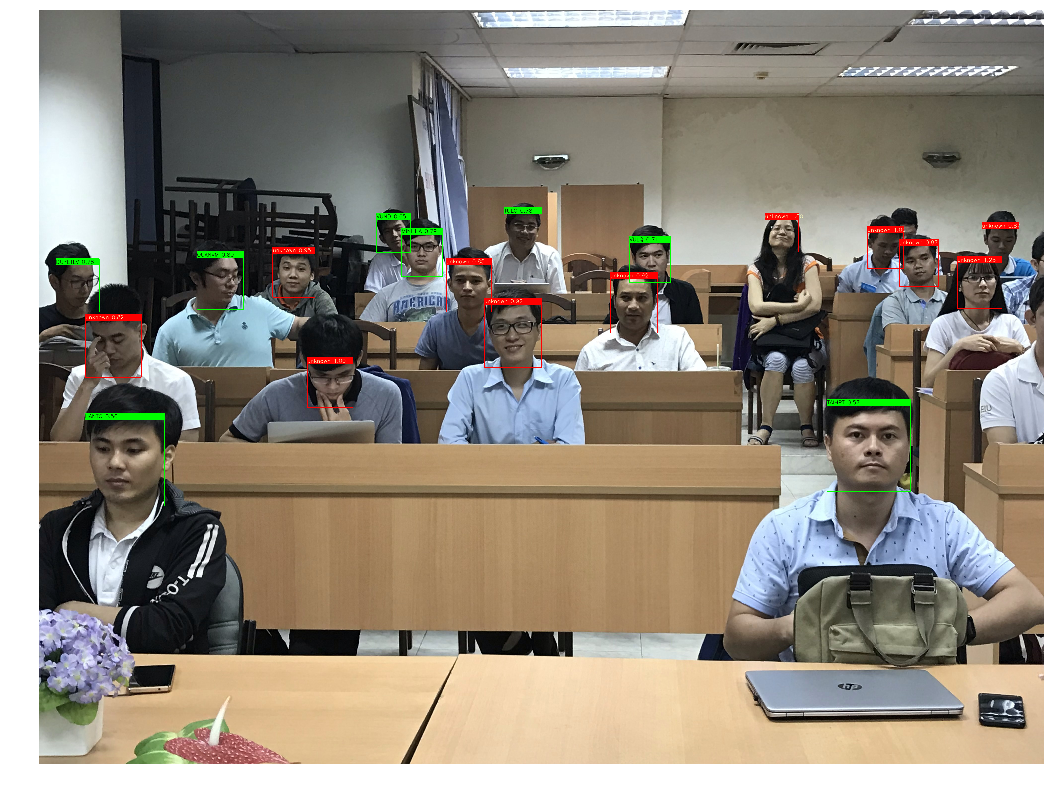

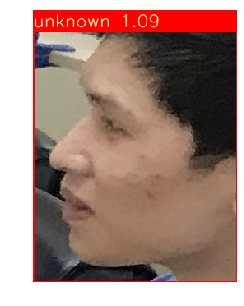

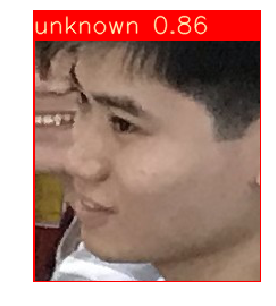

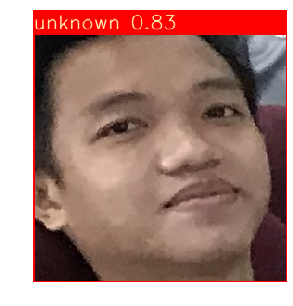

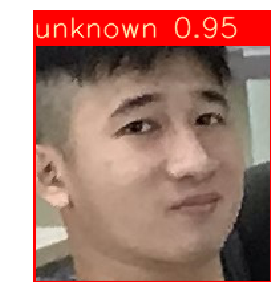

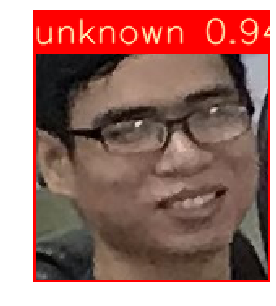

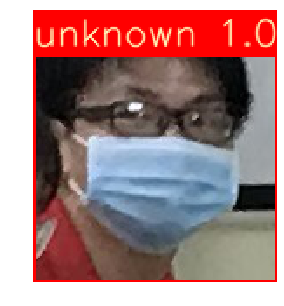

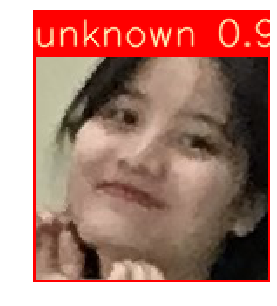

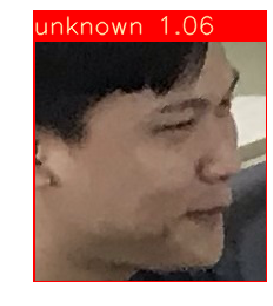

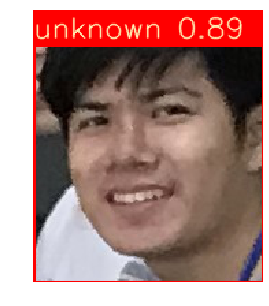

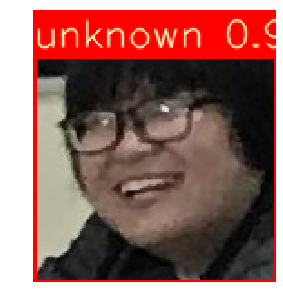

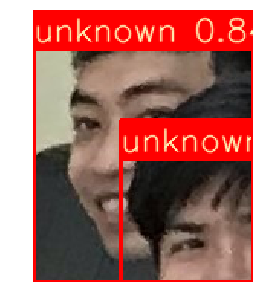

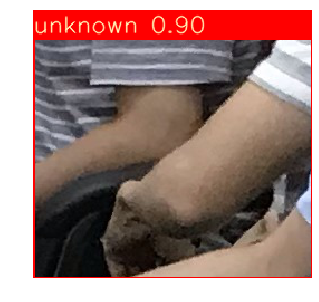

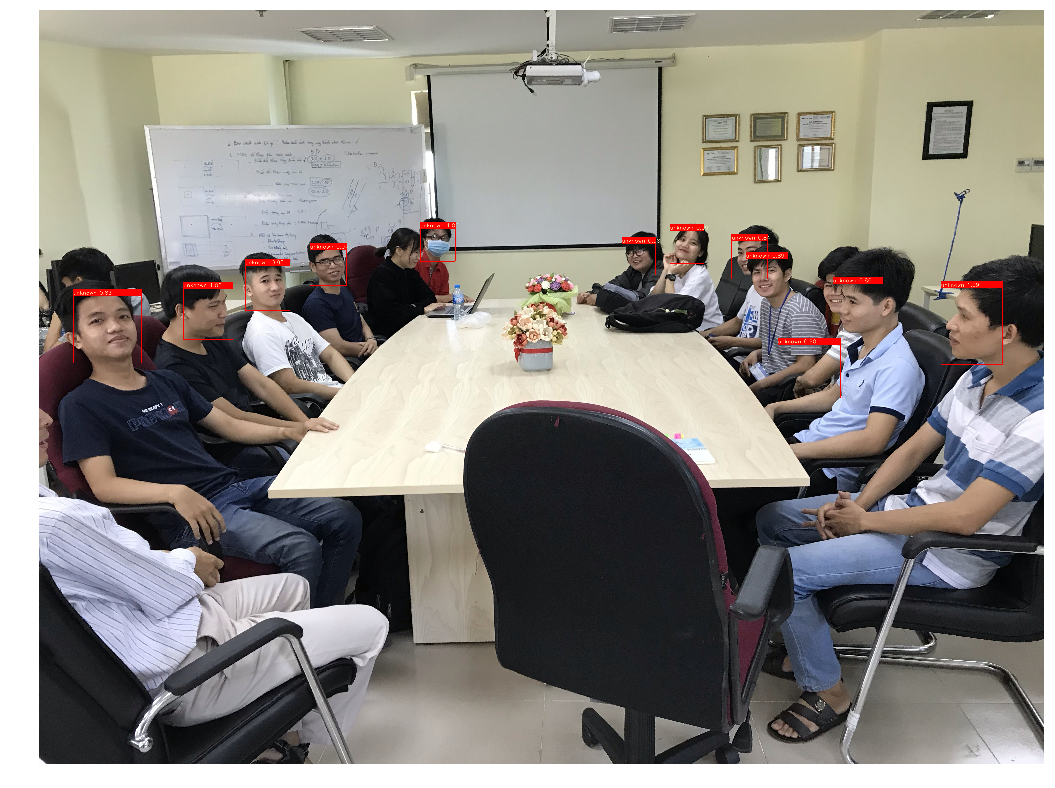

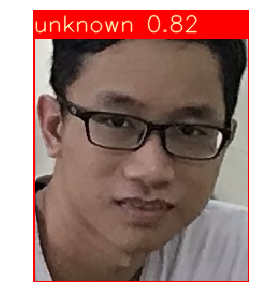

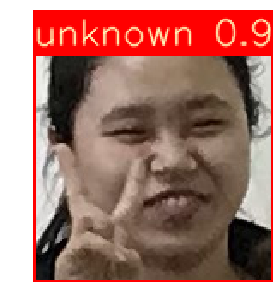

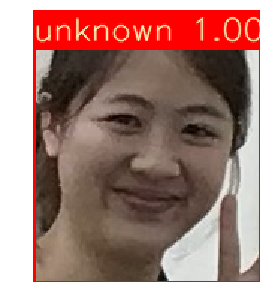

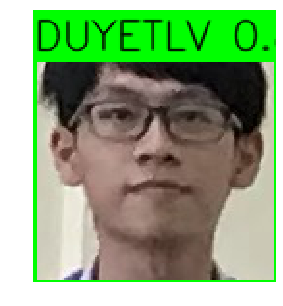

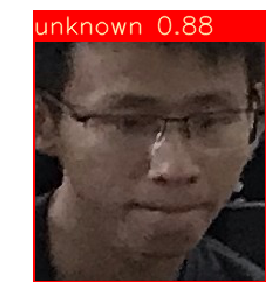

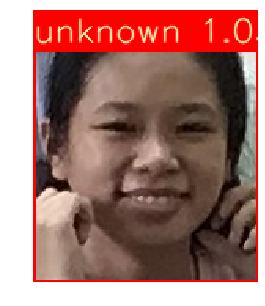

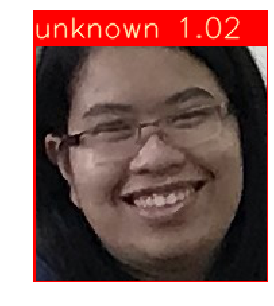

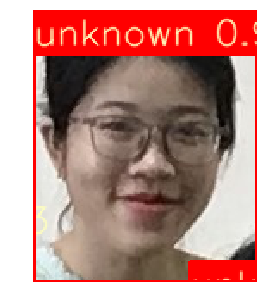

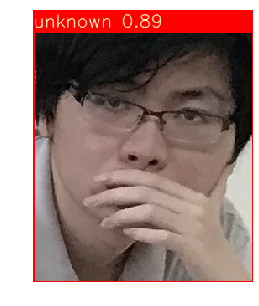

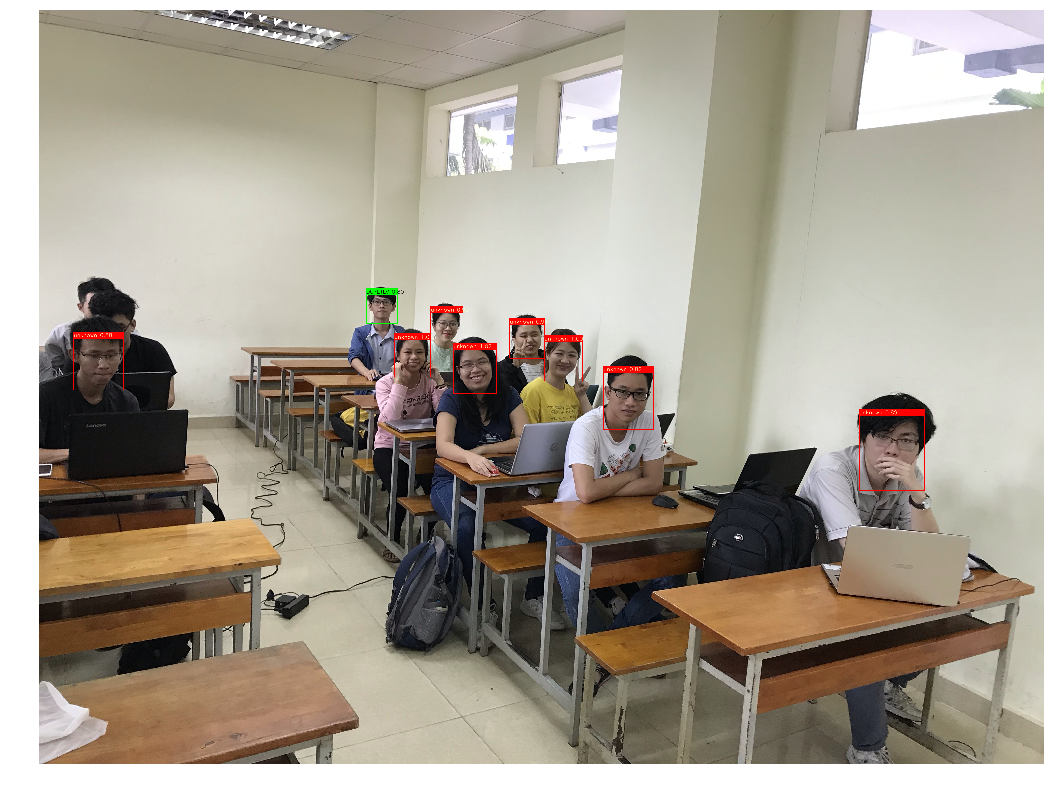

In [9]:
def recognize_face (sess, pnet, rnet, onet,feature_array):
        # Get input and output tensors
        images_placeholder = sess.graph.get_tensor_by_name("input:0")
        images_placeholder = tf.image.resize_images(images_placeholder,(160,160))
        embeddings = sess.graph.get_tensor_by_name("embeddings:0")
        phase_train_placeholder = sess.graph.get_tensor_by_name("phase_train:0")

        embedding_size = embeddings.get_shape()[1]

        for img_file in img_files:
                gray      = imageio.imread(img_path + "/" + img_file)
                
                response, faces, bboxs = align_face(gray, pnet, rnet, onet)

                if (response == True):
                    for i, image in enumerate(faces):
                        bb = bboxs[i]
                        images = load_img(image, False, False, image_size)

                        feed_dict = { images_placeholder:images, phase_train_placeholder:False }
                        #feature_vector = sess.run(embeddings, feed_dict=feed_dict)
                        feature_vector = sess.run(embeddings, feed_dict)

                        result, diff = identify_person(feature_vector, feature_array, 5)
                        #print(result.split("/")[2])

                        W = int(bb[2]-bb[0])//2
                        H = int(bb[3]-bb[1])//2

                        if(result.split("/")[0] == 'unknown'):
                            cv2.rectangle(gray,(bb[0],bb[1]),(bb[2],bb[3]),(255,0,0),2)
                            cv2.rectangle(gray,(bb[0]-1,bb[1]),(bb[2]+1,bb[1]+26),(255,0,0),cv2.FILLED)
                            
                            cv2.putText(gray, result.split("/")[0] + " " + str('%.2f' % diff),(bb[0],bb[1]+20), cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,191),1,cv2.LINE_AA)
                            
                        else:
                            cv2.rectangle(gray,(bb[0],bb[1]),(bb[2],bb[3]),(0,255,0),2)
                            cv2.rectangle(gray,(bb[0]-1,bb[1]),(bb[2]+1,bb[1]+26),(0,255,0),cv2.FILLED)
                            
                            cv2.putText(gray, result.split("/")[0] + " " + str('%.2f' % diff),(bb[0],bb[1]+20), cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,0),1,cv2.LINE_AA)
                            
                        img_face = gray[bb[1]:bb[3], bb[0]:bb[2]]        
                        plt.rcParams['figure.figsize'] = [5, 5]
                        plt.figure()
                        plt.axis('off')
                        plt.imshow(img_face)

                    plt.rcParams['figure.figsize'] = [18, 18]
                    plt.figure()
                    plt.axis('off')
                    plt.imshow(gray)

# Recognize face
recognize_face (sess_tf, pnet, rnet, onet, feature_array)

### Tài liệu tham khảo
1. Florian Schroff, Dmitry Kalenichenko, James Philbin, FaceNet: A Unified Embedding for Face Recognition and Clustering - https://arxiv.org/abs/1503.03832
1. Vinayak Arannil, Building a real time Face Recognition system using pre-trained FaceNet model - https://github.com/vinayakkailas/face_recognition